In [29]:
import xarray as xr
import cf_xarray
import numpy as np
import jax
from jax import numpy as jnp
import optax
import matplotlib.pyplot as plt

In [3]:
from neutralocean.surface import potential_surf, anomaly_surf, omega_surf
import neutralocean.grid.rectilinear

In [121]:
ds = xr.open_mfdataset("../data/*_woa.nc").transpose(
    "x_c", "x_f", "y_c", "y_f", "z_c", "z_f", ...
)
ds

<xarray.Dataset> Size: 476MB
Dimensions:          (x_f: 360, y_c: 180, z_c: 102, x_c: 360, y_f: 180, z_f: 102)
Coordinates: (12/17)
    lat              (y_c) float32 720B dask.array<chunksize=(180,), meta=np.ndarray>
    depth            (z_c) float32 408B dask.array<chunksize=(102,), meta=np.ndarray>
    lon              (x_c) float32 1kB dask.array<chunksize=(360,), meta=np.ndarray>
    lon_right        (x_f) float32 1kB dask.array<chunksize=(360,), meta=np.ndarray>
    lat_right        (y_f) float32 720B dask.array<chunksize=(180,), meta=np.ndarray>
  * x_c              (x_c) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
    ...               ...
    e2               float32 4B 1.11e+05
    e1vf             (y_f) float32 720B dask.array<chunksize=(180,), meta=np.ndarray>
    e3t              (z_c) float32 408B dask.array<chunksize=(102,), meta=np.ndarray>
    depth_right      (z_f) float32 408B dask.array<chunksize=(102,), meta=np.ndarray>
  * z_f              (z_f) int64 816B 0 1 2 3 4 5 6 7 ... 95 96 97 98 99 100 101
    e3w              (z_f) float32 408B dask.array<chunksize=(102,), meta=np.ndarray>
Data variables:
    ex               (x_f, y_c, z_c) float64 53MB dask.array<chunksize=(360, 180, 102), meta=np.ndarray>
    ey               (x_c, y_f, z_c) float64 53MB dask.array<chunksize=(360, 180, 102), meta=np.ndarray>
    grad_h_z_U       (x_f, y_c, z_c) float64 53MB dask.array<chunksize=(360, 180, 102), meta=np.ndarray>
    grad_h_z_V       (x_c, y_f, z_c) float64 53MB dask.array<chunksize=(360, 180, 102), meta=np.ndarray>
    ey_neutralocean  (x_c, y_f, z_c) float64 53MB dask.array<chunksize=(360, 180, 102), meta=np.ndarray>
    ex_neutralocean  (x_f, y_c, z_c) float64 53MB dask.array<chunksize=(360, 180, 102), meta=np.ndarray>
    t_an             (x_c, y_c, z_c) float32 26MB dask.array<chunksize=(180, 90, 51), meta=np.ndarray>
    s_an             (x_c, y_c, z_c) float32 26MB dask.array<chunksize=(180, 90, 51), meta=np.ndarray>
    p                (y_c, z_c) float64 147kB dask.array<chunksize=(180, 102), meta=np.ndarray>
    SA               (x_c, y_c, z_c) float64 53MB dask.array<chunksize=(360, 180, 102), meta=np.ndarray>
    CT               (x_c, y_c, z_c) float64 53MB dask.array<chunksize=(360, 180, 102), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                     CF-1.6
    title:                           World Ocean Atlas 2023 : sea_water_pract...
    summary:                         Climatological mean salinity for the glo...
    references:                      Reagan, J.R., D. Seidov, Z. Wang, D. Duk...
    institution:                     NOAA National Centers for Environmental ...
    comment:                         Global Climatology as part of the World ...
    ...                              ...
    ncei_template_version:           NCEI_NetCDF_Grid_Template_v1.0
    license:                         These data are openly available to the p...
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    metadata_link:                   https://www.ncei.noaa.gov/products/world...
    date_created:                    2024-01-28 
    date_modified:                   2024-01-28

In [122]:
ds[[i for i in ds if "y_c" in ds[i].dims]] = ds[[i for i in ds if "y_c" in ds[i].dims]].where(ds.lat<65)
ds[[i for i in ds if "y_f" in ds[i].dims]] = ds[[i for i in ds if "y_f" in ds[i].dims]].where(ds.lat_right<65)

In [123]:
ni, nj, nk = ds.cf["sea_water_conservative_temperature"].shape
neutralocean_grid = neutralocean.grid.rectilinear.build_grid(
    dims=(ni, nj),
    periodic=(True, False),
    dxC=ds.e1tu,
    dyC=ds.e2,
    dxG=ds.e1vf,
    dyG=ds.e2
)

In [124]:
i0, j0 = 180, 110
z0 = 1500.0

In [125]:
# we simply provide a 1st guess

args = {}
args["grid"] = neutralocean_grid
args["pin_cast"] = (i0, j0)
#args["p_ml"] = {"bottle_index": 1, "ref_p": 0.0}  # see `mixed_layer` for info
s, t, z, d = potential_surf(
    ds.cf["sea_water_absolute_salinity"],
    ds.cf["sea_water_conservative_temperature"],
    ds.depth.broadcast_like(ds.cf["sea_water_absolute_salinity"]),
    **args,
    vert_dim=-1,
    #isoval=1027.5,
    ref=1500.,
    pin_p=1500.
)

potential done |       31166 wet casts | RMS(ϵ) = 4.22002064e-14  | 0.110 sec


In [126]:
%%time
s_omega, t_omega, z_omega, d = omega_surf(
    ds.cf["sea_water_absolute_salinity"],
    ds.cf["sea_water_conservative_temperature"],
    ds.depth.broadcast_like(ds.cf["sea_water_absolute_salinity"]),
    **args,
    vert_dim=-1,
    p_init=z,
    ITER_MAX=50
)

iter |    MAV(ϕ)     |    RMS(Δp)      | # wet casts (# new) |     RMS(ϵ)     | time (s)
   0 |                                 |       31166         | 4.22002064e-14 | 0.009
   1 | 1.32472986e-08 | 1.99080541e+01 |       30919 (   37) | 1.83262365e-15 | 0.140
   2 | 4.21280318e-10 | 1.13582391e+00 |       31934 ( 1021) | 4.62078654e-16 | 0.135
   3 | 2.22239148e-11 | 9.31337343e-02 |       31936 (    2) | 4.57683376e-16 | 0.135
   4 | 1.17539083e-12 | 7.05014168e-03 |       31936 (    0) | 4.57658147e-16 | 0.133
   5 | 6.22902579e-14 | 4.81576537e-04 |       31936 (    0) | 4.57657845e-16 | 0.128
CPU times: user 916 ms, sys: 87.7 ms, total: 1 s
Wall time: 1.02 s


## Cost function!

we take the MSE of difference of gradients

In [127]:
# convert arrays of grad_h_z and depth into jax arrays

grad_h_z_U = jnp.asarray(ds.grad_h_z_U)
grad_h_z_V = jnp.asarray(ds.grad_h_z_V)
depth_U = jnp.asarray(ds.depth.broadcast_like(ds.grad_h_z_U))
depth_V = jnp.asarray(ds.depth.broadcast_like(ds.grad_h_z_V))

e1u = jnp.asarray(ds.e1tu)
e2v = jnp.asarray(ds.e2)

In [128]:
interp_1d_at_every_point = jax.vmap(jax.vmap(jnp.interp, in_axes=0), in_axes=0)

In [129]:
def compute_slope_of_surface_along_axis(surface, axis, e):
    """
    surface : 2D arrays, shape (x,y)
    axis : axis on which to compute gradient, 0 for x, 1 for y
    e : scale factor
    """
    return (jnp.roll(surface, -1, axis) - surface) / e

In [130]:
umask = jnp.where(
    jnp.isfinite(
        compute_slope_of_surface_along_axis((ds.SA.isel(z_c=0)*0+1).values, 0, 1.)
    ),
    1,
    0
)

vmask = jnp.where(
    jnp.isfinite(
        compute_slope_of_surface_along_axis((ds.SA.isel(z_c=0)*0+1).values, 1, 1.)
    ),
    1,
    0
)

In [331]:
# Let’s imagine that the surface we want is the one we start with
# to test the optimization functions
# and we will add some noise onto the initial surface

grad_h_z_U = compute_slope_of_surface_along_axis(z.values, axis=0, e=e1u)*0
grad_h_z_V = compute_slope_of_surface_along_axis(z.values, axis=1, e=e2v)*0

grad_h_z_U = jnp.broadcast_to(grad_h_z_U[:,:,None], (grad_h_z_U.shape[0], grad_h_z_U.shape[1], ds.depth.shape[0]))
grad_h_z_V = jnp.broadcast_to(grad_h_z_V[:,:,None], (grad_h_z_V.shape[0], grad_h_z_V.shape[1], ds.depth.shape[0]))

In [332]:
def compute_neutral_slope_along_surface_x(surface):
    out = interp_1d_at_every_point(
        x=(jnp.roll(surface,-1,0) + surface)/2, # interpolated at U point
        xp=depth_U,
        fp=grad_h_z_U
    )
    return out

def compute_neutral_slope_along_surface_y(surface):
    out = interp_1d_at_every_point(
        x=(jnp.roll(surface,-1,1) + surface)/2, # interpolated at V point
        xp=depth_V,
        fp=grad_h_z_V
    )
    return out

In [507]:
def floss(surface):
    grad_U = jnp.nan_to_num(compute_slope_of_surface_along_axis(surface, axis=0, e=e1u))
    grad_V = jnp.nan_to_num(compute_slope_of_surface_along_axis(surface, axis=1, e=e2v))
    neutral_slope_U = jnp.nan_to_num(compute_neutral_slope_along_surface_x(surface))
    neutral_slope_V = jnp.nan_to_num(compute_neutral_slope_along_surface_y(surface))
    return jnp.nansum((grad_U - neutral_slope_U)**2 * umask + (grad_V - neutral_slope_V)**2 * vmask) *1e6+ (surface[180,90])**2
    #return jnp.nansum( (grad_V - neutral_slope_V)**2*vmask) *1e6+ (surface[180,90])**2

In [508]:
floss(z.values)

Array(2365995., dtype=float32)

In [509]:
floss(z_omega.values)

Array(2365635.5, dtype=float32)

In [510]:
floss(z_omega.values*0)

Array(0., dtype=float32)

## Optimization

In [511]:
# why do we jit?
#@jax.jit
#def compute_loss_and_grads(params):
#    """Compute loss and gradients"""
#    return jax.value_and_grad(loss)(params)

grad_loss = jax.grad(floss)

def train(params, learning_rate=0.01, num_steps=1000):
    """Train using gradient descent optimization"""
    # Define optimizer
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
    
    losses = []
    
    for step in range(num_steps):
        # Compute loss and gradients
        loss = floss(params)
        #grads = jnp.nan_to_num(grad_loss(params))
        grads = grad_loss(params)
        
        losses.append(loss)
        
        # Apply updates
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        
        # Print progress every 100 steps
        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss}")
            plt.imshow(params.T)
            plt.show()
    
    return params, losses

In [512]:
initial_surface = jnp.asarray((z*0 + ds.lat).values)

In [513]:
floss(initial_surface)

Array(2.6994765, dtype=float32)

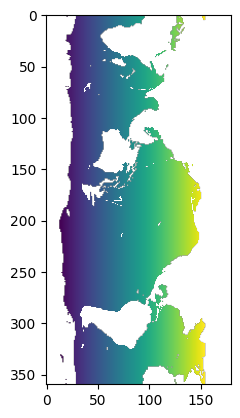

In [514]:
plt.imshow(initial_surface)

In [515]:
g = grad_loss(initial_surface)

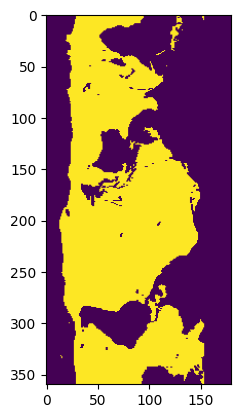

In [516]:
plt.imshow(jnp.nan_to_num(compute_slope_of_surface_along_axis(initial_surface, axis=1, e=e2v))*vmask)

In [517]:
jnp.nanmin((compute_slope_of_surface_along_axis(initial_surface, axis=1, e=e2v))*vmask)

Array(9.009009e-06, dtype=float32)

In [518]:
ds["gradient"] = xr.DataArray(g, dims=("x_c", "y_c"))

In [519]:
initial_surface[180,90]

Array(0.5, dtype=float32)

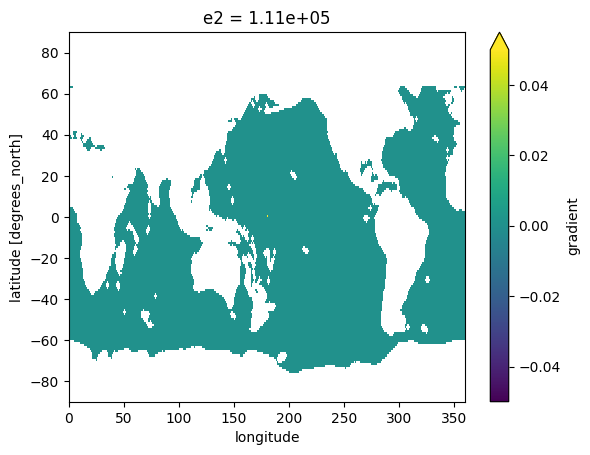

In [520]:
ds["gradient"].where(np.isfinite(ds.SA.isel(z_c=0)).values).plot(robust=True, x="lon", y="lat")


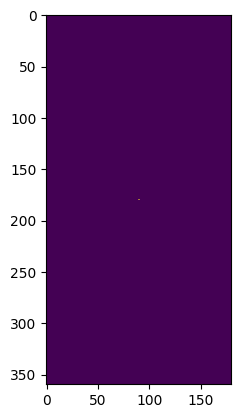

In [521]:
plt.imshow(g>0)

Step 0, Loss: 2.699476480484009


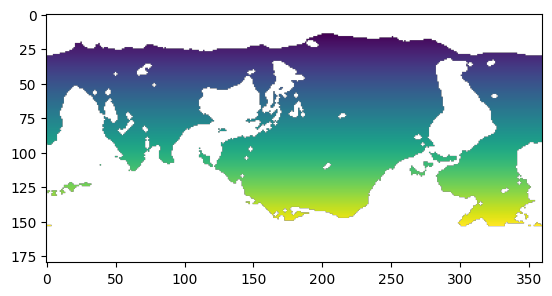

Step 100, Loss: 1.482633352279663


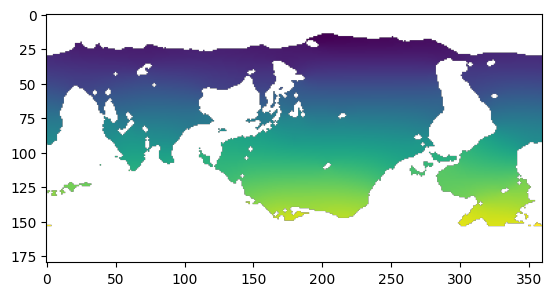

Step 200, Loss: 1.106773853302002


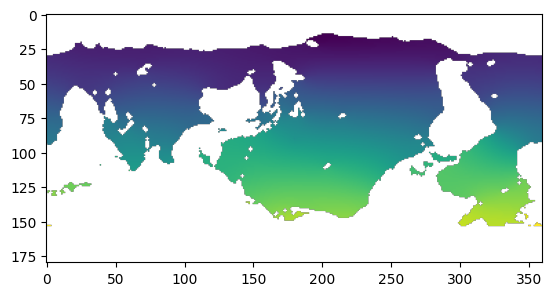

Step 300, Loss: 0.8516156077384949


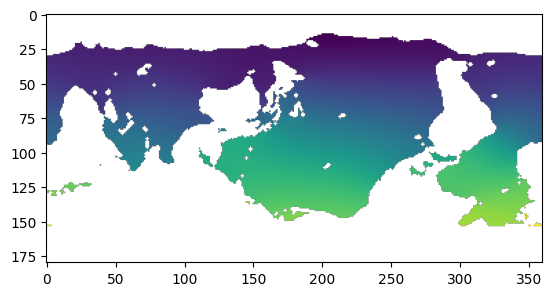

Step 400, Loss: 0.6653788685798645


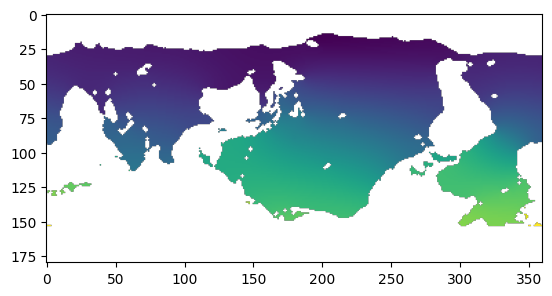

Step 500, Loss: 0.5257351994514465


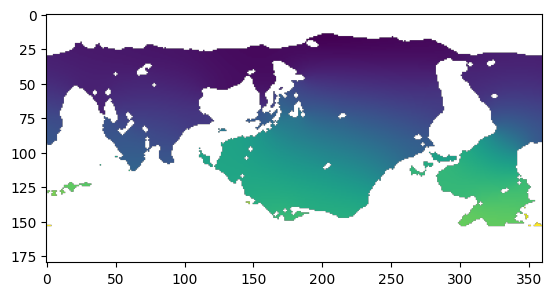

Step 600, Loss: 0.41970762610435486


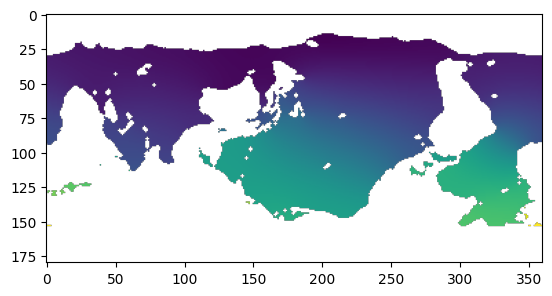

Step 700, Loss: 0.33864134550094604


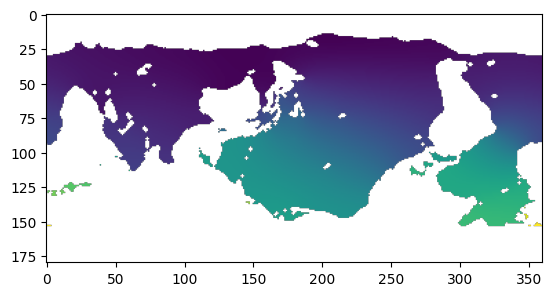

Step 800, Loss: 0.2762881815433502


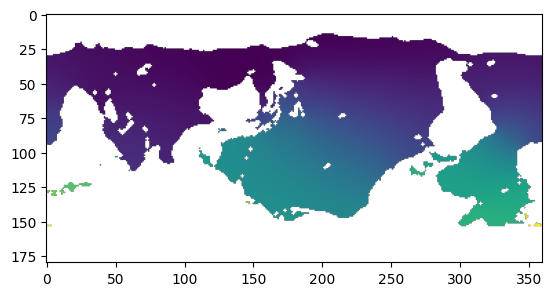

Step 900, Loss: 0.22821149230003357


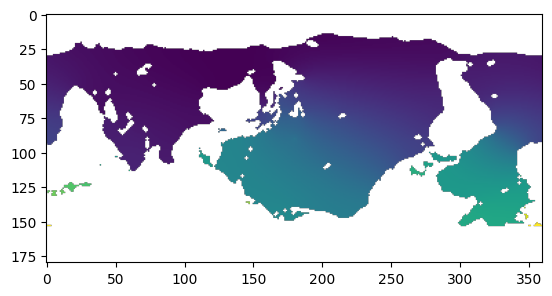

Step 1000, Loss: 0.19082726538181305


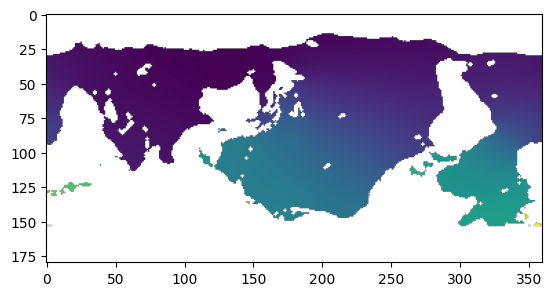

Step 1100, Loss: 0.16150261461734772


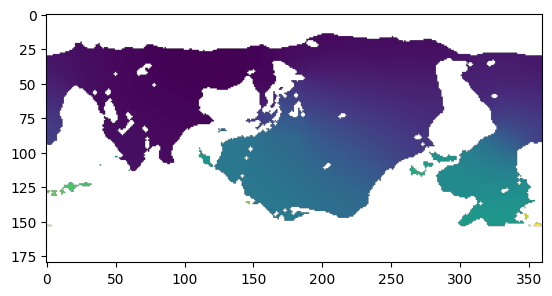

Step 1200, Loss: 0.1383424699306488


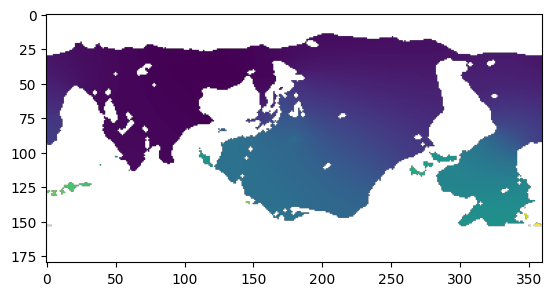

Step 1300, Loss: 0.11995507776737213


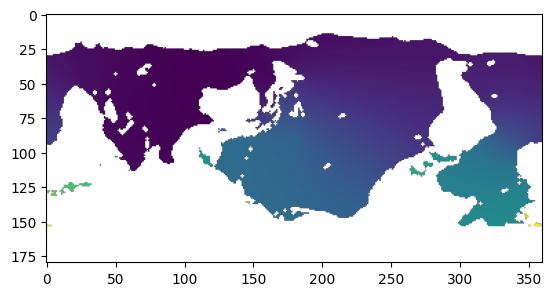

Step 1400, Loss: 0.10515326261520386


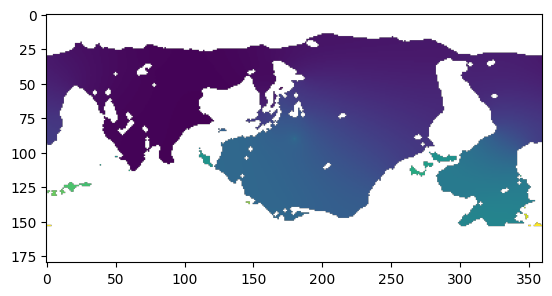

Step 1500, Loss: 0.0930292084813118


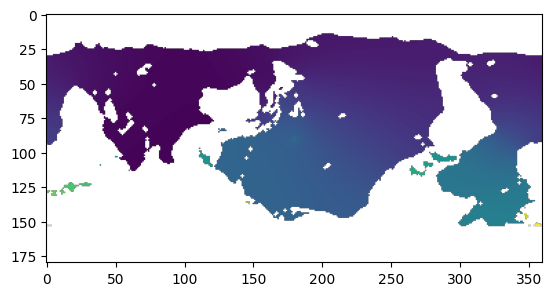

Step 1600, Loss: 0.08317694813013077


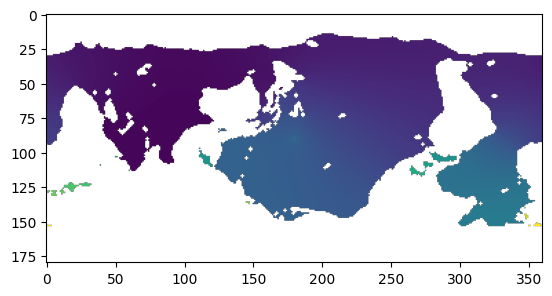

Step 1700, Loss: 0.07495226711034775


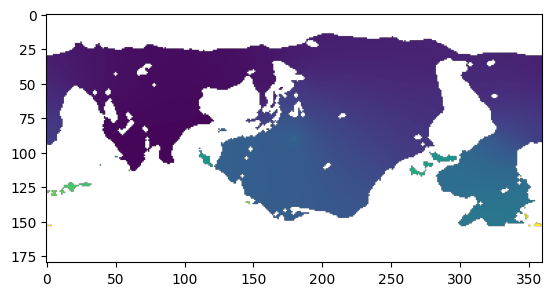

Step 1800, Loss: 0.06807225197553635


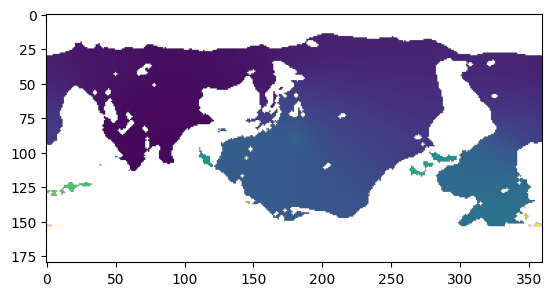

Step 1900, Loss: 0.062263406813144684


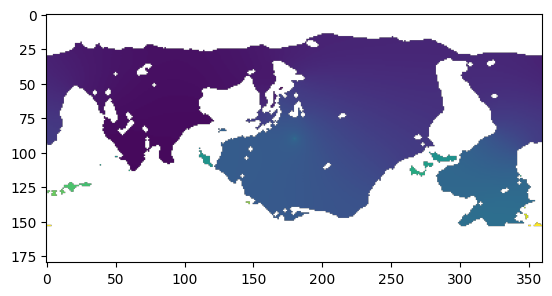

Optimization complete!
Initial loss: 2.699476480484009
Final loss: 0.057160791009664536


In [522]:
#initial_surface = jnp.asarray(z.values + np.random.normal(scale=1, size=z.shape))
    
# Run optimization
optimal_surface, loss_history = train(
    initial_surface, 
    learning_rate=.1, 
    num_steps=2000
)

print("Optimization complete!")
print(f"Initial loss: {floss(initial_surface)}")
print(f"Final loss: {floss(optimal_surface)}")

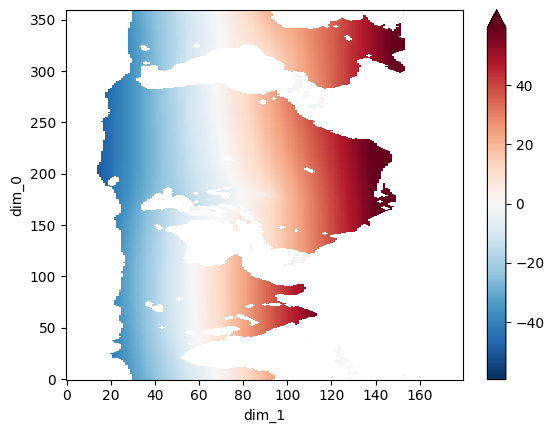

In [523]:
xr.DataArray(initial_surface- optimal_surface).plot(robust=True)

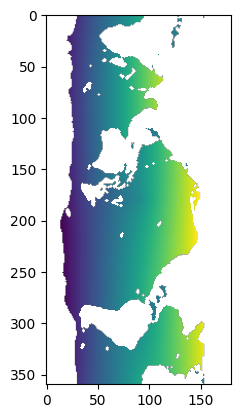

In [524]:
plt.imshow(initial_surface- optimal_surface)